# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, precision_score, average_precision_score, balanced_accuracy_score, log_loss, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.mixture import GaussianMixture
from joblib import Parallel, delayed
from copy import deepcopy

# Config

In [2]:
# Matplotlib styling
mpl.style.use("seaborn-white")

# For parallel processing
N_CORES = 8

# Random classification data generator
N_SAMPLES = 5000
WEIGHTS = [0.95, 0.05]

# Number of 1s required in oversampled data
N_ROWS_1 = 2000

# Generating imbalanced classification dataset

In [3]:
X, y = make_classification(
    n_samples=N_SAMPLES, n_classes=2, 
    weights=WEIGHTS, flip_y=0, random_state=1
)

/Users/bkarami/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


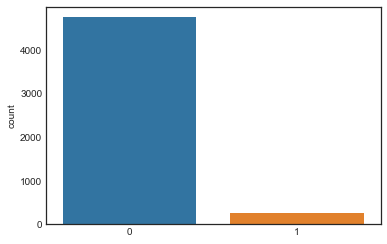

In [4]:
sns.countplot(y)
plt.show()

# Random Oversampling

In [5]:
# Random oversampling
def oversample_random(X, y, rows_1, random_state):
    '''Accepts X and y arrays along with the number of
    required positively labeled samples (rows_1). Returns
    randomly oversampled positively labeled data.
    '''
    X_random, y_random = RandomOverSampler(
        sampling_strategy={1: rows_1},
        random_state=random_state
    ).fit_resample(X_train, y_train)
    
    return X_random, y_random

# SMOTE

In [6]:
# SMOTE
def oversample_smote(X, y, rows_1, k_neighbors, random_state):
    '''Accepts X and y arrays along with the number of
    required positively labeled samples (rows_1) and number
    of nearest neighbors to consider in the SMOTE algorithm. 
    Returns SMOTE oversampled positively labeled data.
    '''
    X_smote, y_smote = SMOTE(
        sampling_strategy={1: rows_1},
        k_neighbors=k_neighbors,
        random_state=random_state
    ).fit_resample(X, y)
    
    return X_smote, y_smote

# GMM

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [8]:
gmm = GaussianMixture(10, random_state=1)
gmm.fit(X_train)

GaussianMixture(n_components=10, random_state=1)

In [9]:
cluster_mean = pd.DataFrame(data={
    "Cluster": gmm.predict(X_train), 
    "Mean Target Variable (y)": y_train
}).groupby("Cluster").mean()

cluster_mean.values.argmax()

1

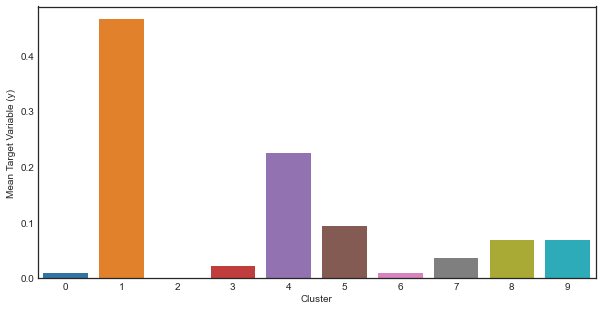

In [10]:
cluster_mean = pd.DataFrame(data={
    "Cluster": gmm.predict(X_train), 
    "Mean Target Variable (y)": y_train
}).groupby("Cluster").mean().reset_index(drop=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=cluster_mean, x="Cluster", y="Mean Target Variable (y)")
plt.show()

In [11]:
cluster_mean.sort_values(
    by='Mean Target Variable (y)', ascending=False)

,Cluster,Mean Target Variable (y)
1,1,0.464968
4,4,0.225806
5,5,0.094203
9,9,0.068027
8,8,0.067901
7,7,0.035928
3,3,0.021320
0,0,0.010417
6,6,0.010309
2,2,0.000000


In [12]:
def oversample_gmm(X, y, rows_1, no_clusters=2, 
                   no_sampling_clusters=1, rs=1):
    # Instantiate GMM model
    gmm = GaussianMixture(
        no_clusters,
        covariance_type='tied', 
        max_iter=10000,
        random_state=rs
    )
    gmm.fit(X)
    
    # Finding cluster with y=1 most likely
    cluster_mean = pd.DataFrame(data={
        "Cluster": gmm.predict(X_train), 
        "Mean Target Variable (y)": y_train
        }).groupby("Cluster").mean().sort_values(
        by='Mean Target Variable (y)', ascending=False)

    top_clusters = cluster_mean.sort_values(
        by='Mean Target Variable (y)', ascending=False).index[
        :no_sampling_clusters]
    
    # Number of rows we will generate before
    # filtering by required cluster.
    # Multiply by 5 to ensure we have sufficient samples
    rows_initial = rows_1 * no_clusters * 5
    
    # Generate samples
    samples, clusters = gmm.sample(rows_initial)

    # Keep samples coming from clusters where y=1 is likely
    top_clusters_filter = [np.any([
        cluster == x for x in top_clusters]
        ) for cluster in clusters]
    samples_to_keep = samples[top_clusters_filter]
    
    # Keep only required number of additional samples
    rows_required = rows_1 - np.sum(y)
    np.random.shuffle(samples_to_keep)
    samples_to_keep = samples_to_keep[:rows_required]
    
    # Add samples to training dataset
    X_gmm = np.vstack([X, samples_to_keep])
    y_gmm = np.hstack([y, np.ones(samples_to_keep.shape[0])])
    
    return X_gmm, y_gmm

# Evaluation

In [13]:
metrics_dict = {"ROC AUC": [],
              "PR AUC": [],
              "Balanced Accuracy": [],
              "Max F1": [],
              "Recall": [],
              "Precision": [],
              "F1": []
               }

results_original = deepcopy(metrics_dict)
results_random = deepcopy(metrics_dict)
results_smote_1 = deepcopy(metrics_dict)
results_smote_3 = deepcopy(metrics_dict)
results_smote_5 = deepcopy(metrics_dict)
results_smote_10 = deepcopy(metrics_dict)
results_gmm_2 = deepcopy(metrics_dict)
results_gmm_3 = deepcopy(metrics_dict)
results_gmm_5 = deepcopy(metrics_dict)
results_gmm_10 = deepcopy(metrics_dict)
results_gmm_15 = deepcopy(metrics_dict)


for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    
    clf = RandomForestClassifier(random_state=i)
    
    X_random, y_random = oversample_random(X_train, y_train, N_ROWS_1, i)
    X_smote_1, y_smote_1 = oversample_smote(X_train, y_train, N_ROWS_1, 1, i)
    X_smote_3, y_smote_3 = oversample_smote(X_train, y_train, N_ROWS_1, 3, i)
    X_smote_5, y_smote_5 = oversample_smote(X_train, y_train, N_ROWS_1, 5, i)
    X_smote_10, y_smote_10 = oversample_smote(X_train, y_train, N_ROWS_1, 10, i)
    X_gmm_2, y_gmm_2 = oversample_gmm(X_train, y_train, N_ROWS_1, no_clusters=2, no_sampling_clusters=1, rs=i)
    X_gmm_3, y_gmm_3 = oversample_gmm(X_train, y_train, N_ROWS_1, no_clusters=3, no_sampling_clusters=1, rs=i)
    X_gmm_5, y_gmm_5 = oversample_gmm(X_train, y_train, N_ROWS_1, no_clusters=5, no_sampling_clusters=1, rs=i)
    X_gmm_10, y_gmm_10 = oversample_gmm(X_train, y_train, N_ROWS_1, no_clusters=10, no_sampling_clusters=1, rs=i)
    X_gmm_15, y_gmm_15 = oversample_gmm(X_train, y_train, N_ROWS_1, no_clusters=15, no_sampling_clusters=1, rs=i)
    
    model = clf.fit(X_train, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_)
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_original["ROC AUC"].append(roc_auc)
    results_original["PR AUC"].append(pr_auc)
    results_original["Max F1"].append(max_f1)
    results_original["Balanced Accuracy"].append(balanced_accuracy)
    results_original["Recall"].append(recall)
    results_original["Precision"].append(precision)
    results_original["F1"].append(f1)
    
    model = clf.fit(X_random, y_random)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_random["ROC AUC"].append(roc_auc)
    results_random["PR AUC"].append(pr_auc)
    results_random["Max F1"].append(max_f1)
    results_random["Balanced Accuracy"].append(balanced_accuracy)
    results_random["Recall"].append(recall)
    results_random["Precision"].append(precision)
    results_random["F1"].append(f1)

    model = clf.fit(X_smote_1, y_smote_1)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_1["ROC AUC"].append(roc_auc)
    results_smote_1["PR AUC"].append(pr_auc)
    results_smote_1["Max F1"].append(max_f1)
    results_smote_1["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_1["Recall"].append(recall)
    results_smote_1["Precision"].append(precision)
    results_smote_1["F1"].append(f1)
    
    model = clf.fit(X_smote_3, y_smote_3)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_3["ROC AUC"].append(roc_auc)
    results_smote_3["PR AUC"].append(pr_auc)
    results_smote_3["Max F1"].append(max_f1)
    results_smote_3["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_3["Recall"].append(recall)
    results_smote_3["Precision"].append(precision)
    results_smote_3["F1"].append(f1)
    
    model = clf.fit(X_smote_5, y_smote_5)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_5["ROC AUC"].append(roc_auc)
    results_smote_5["PR AUC"].append(pr_auc)
    results_smote_5["Max F1"].append(max_f1)
    results_smote_5["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_5["Recall"].append(recall)
    results_smote_5["Precision"].append(precision)
    results_smote_5["F1"].append(f1)
    
    model = clf.fit(X_smote_10, y_smote_10)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_smote_10["ROC AUC"].append(roc_auc)
    results_smote_10["PR AUC"].append(pr_auc)
    results_smote_10["Max F1"].append(max_f1)
    results_smote_10["Balanced Accuracy"].append(balanced_accuracy)
    results_smote_10["Recall"].append(recall)
    results_smote_10["Precision"].append(precision)
    results_smote_10["F1"].append(f1)
    
    model = clf.fit(X_gmm_2, y_gmm_2)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_gmm_2["ROC AUC"].append(roc_auc)
    results_gmm_2["PR AUC"].append(pr_auc)
    results_gmm_2["Max F1"].append(max_f1)
    results_gmm_2["Balanced Accuracy"].append(balanced_accuracy)
    results_gmm_2["Recall"].append(recall)
    results_gmm_2["Precision"].append(precision)
    results_gmm_2["F1"].append(f1)
    
    model = clf.fit(X_gmm_3, y_gmm_3)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_gmm_3["ROC AUC"].append(roc_auc)
    results_gmm_3["PR AUC"].append(pr_auc)
    results_gmm_3["Max F1"].append(max_f1)
    results_gmm_3["Balanced Accuracy"].append(balanced_accuracy)
    results_gmm_3["Recall"].append(recall)
    results_gmm_3["Precision"].append(precision)
    results_gmm_3["F1"].append(f1)

    model = clf.fit(X_gmm_5, y_gmm_5)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_gmm_5["ROC AUC"].append(roc_auc)
    results_gmm_5["PR AUC"].append(pr_auc)
    results_gmm_5["Max F1"].append(max_f1)
    results_gmm_5["Balanced Accuracy"].append(balanced_accuracy)
    results_gmm_5["Recall"].append(recall)
    results_gmm_5["Precision"].append(precision)
    results_gmm_5["F1"].append(f1)
    
    model = clf.fit(X_gmm_10, y_gmm_10)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_gmm_10["ROC AUC"].append(roc_auc)
    results_gmm_10["PR AUC"].append(pr_auc)
    results_gmm_10["Max F1"].append(max_f1)
    results_gmm_10["Balanced Accuracy"].append(balanced_accuracy)
    results_gmm_10["Recall"].append(recall)
    results_gmm_10["Precision"].append(precision)
    results_gmm_10["F1"].append(f1)
    
    model = clf.fit(X_gmm_15, y_gmm_15)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision_, recall_, _ = precision_recall_curve(
        y_test, model.predict_proba(X_test)[:, 1])
    f1_ = (2*precision_*recall_) / (recall_+precision_) 
    pr_auc = auc(recall_, precision_)
    max_f1 = np.max(f1_)
    recall = recall_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    balanced_accuracy = balanced_accuracy_score(y_test, model.predict(X_test))
    results_gmm_15["ROC AUC"].append(roc_auc)
    results_gmm_15["PR AUC"].append(pr_auc)
    results_gmm_15["Max F1"].append(max_f1)
    results_gmm_15["Balanced Accuracy"].append(balanced_accuracy)
    results_gmm_15["Recall"].append(recall)
    results_gmm_15["Precision"].append(precision)
    results_gmm_15["F1"].append(f1)

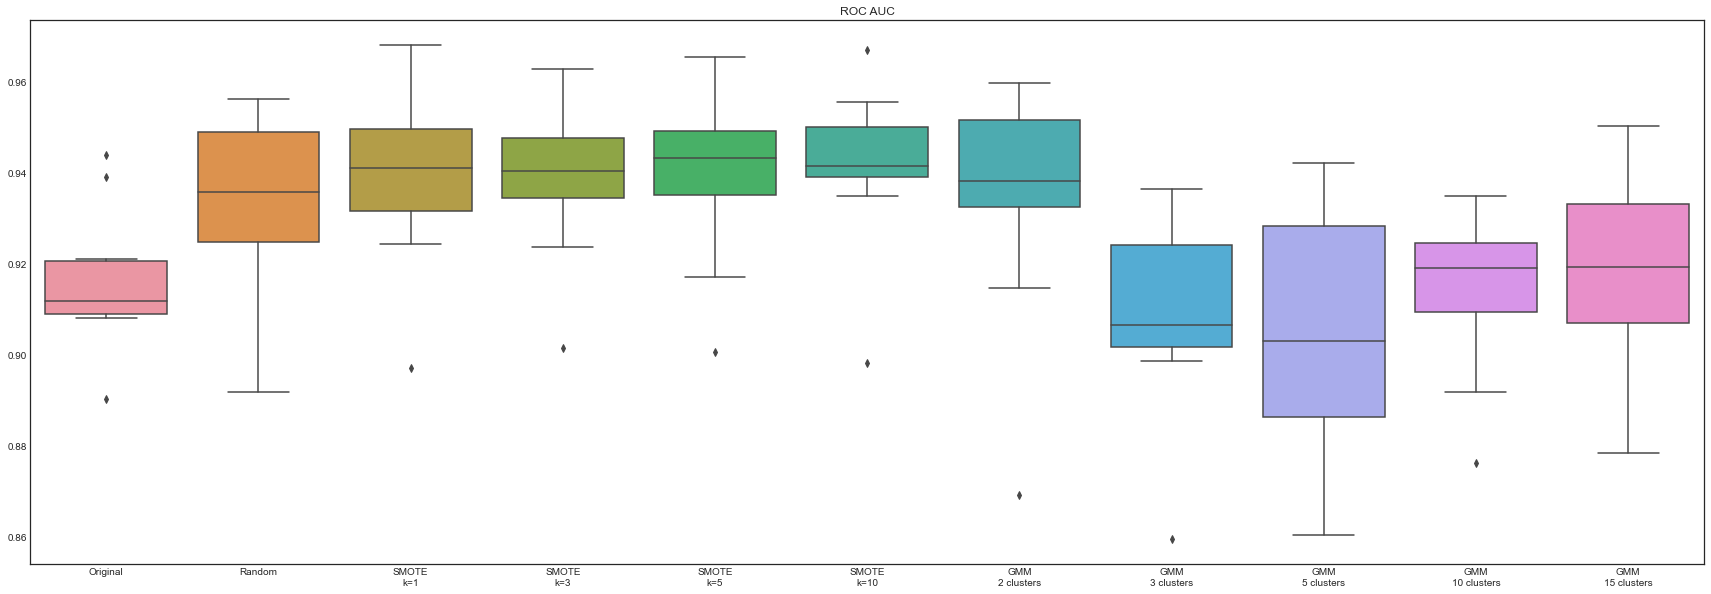

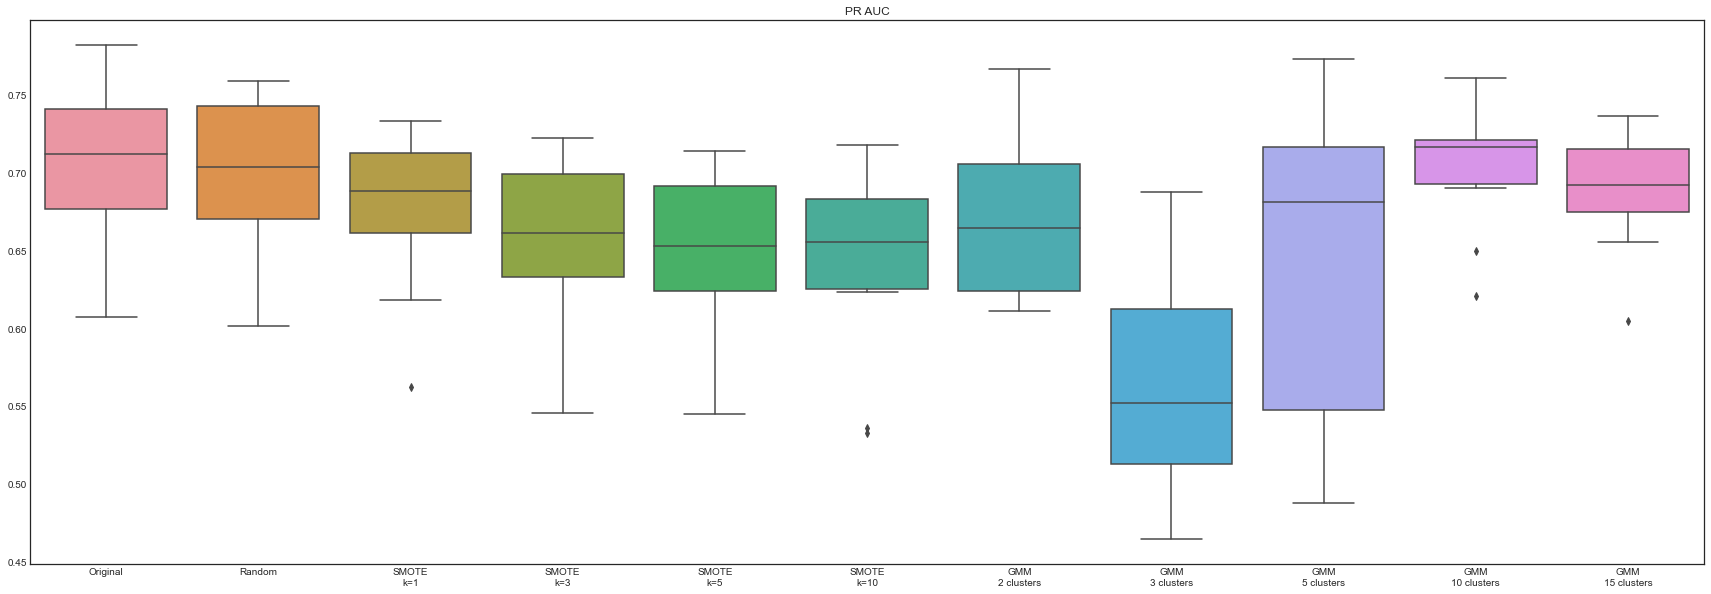

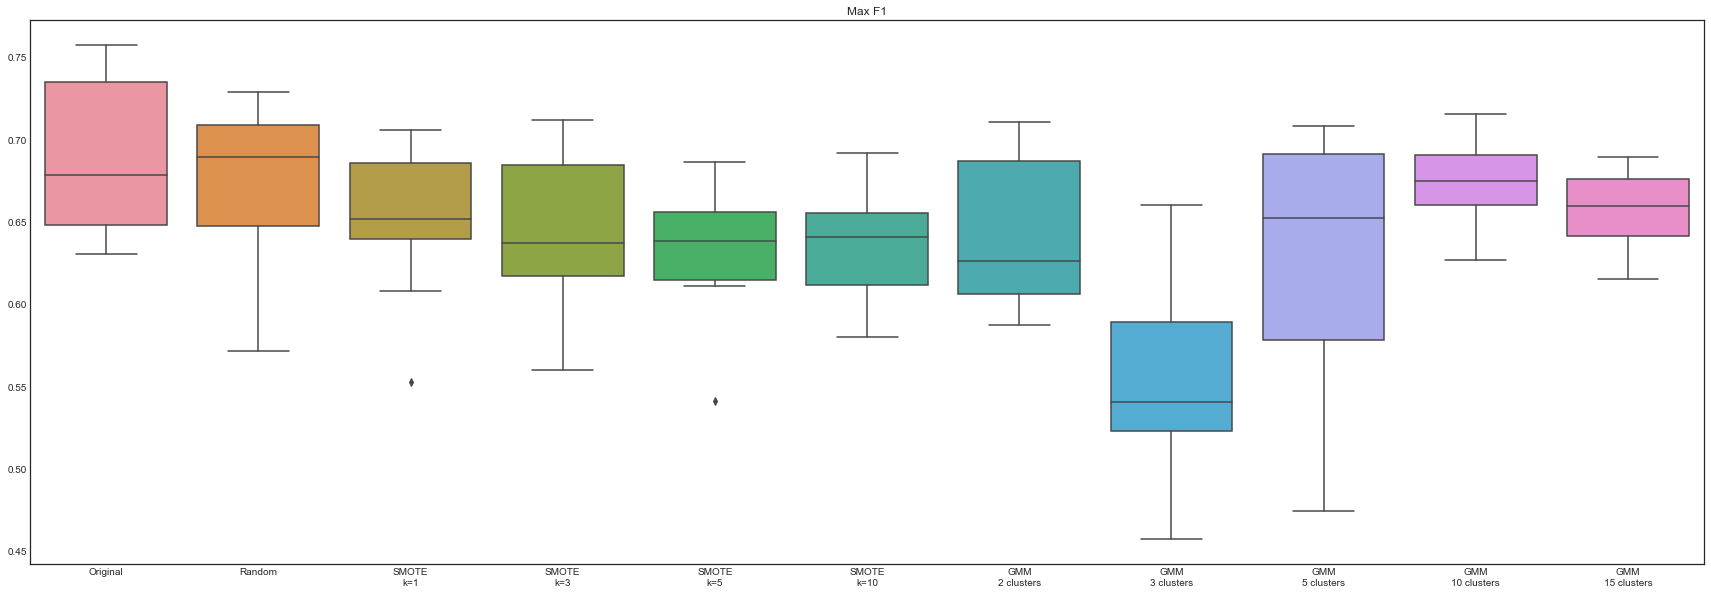

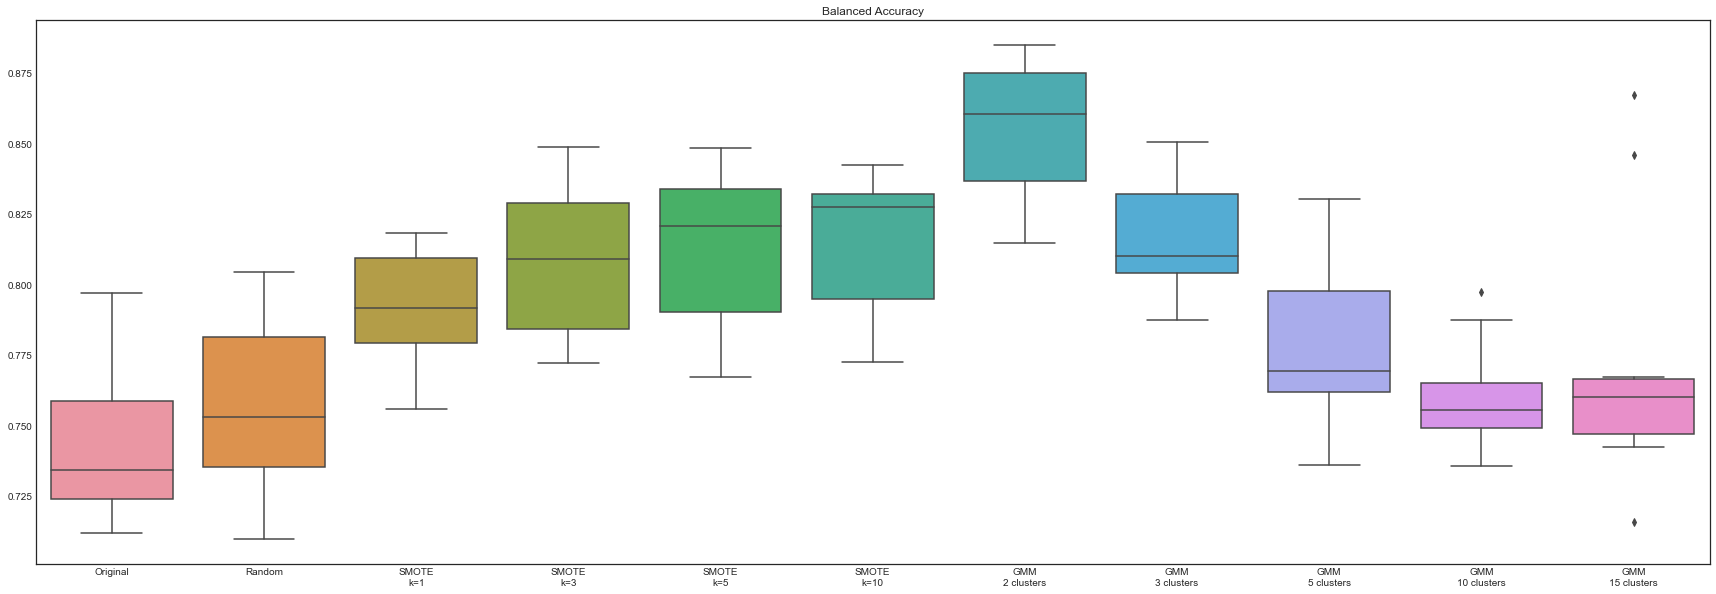

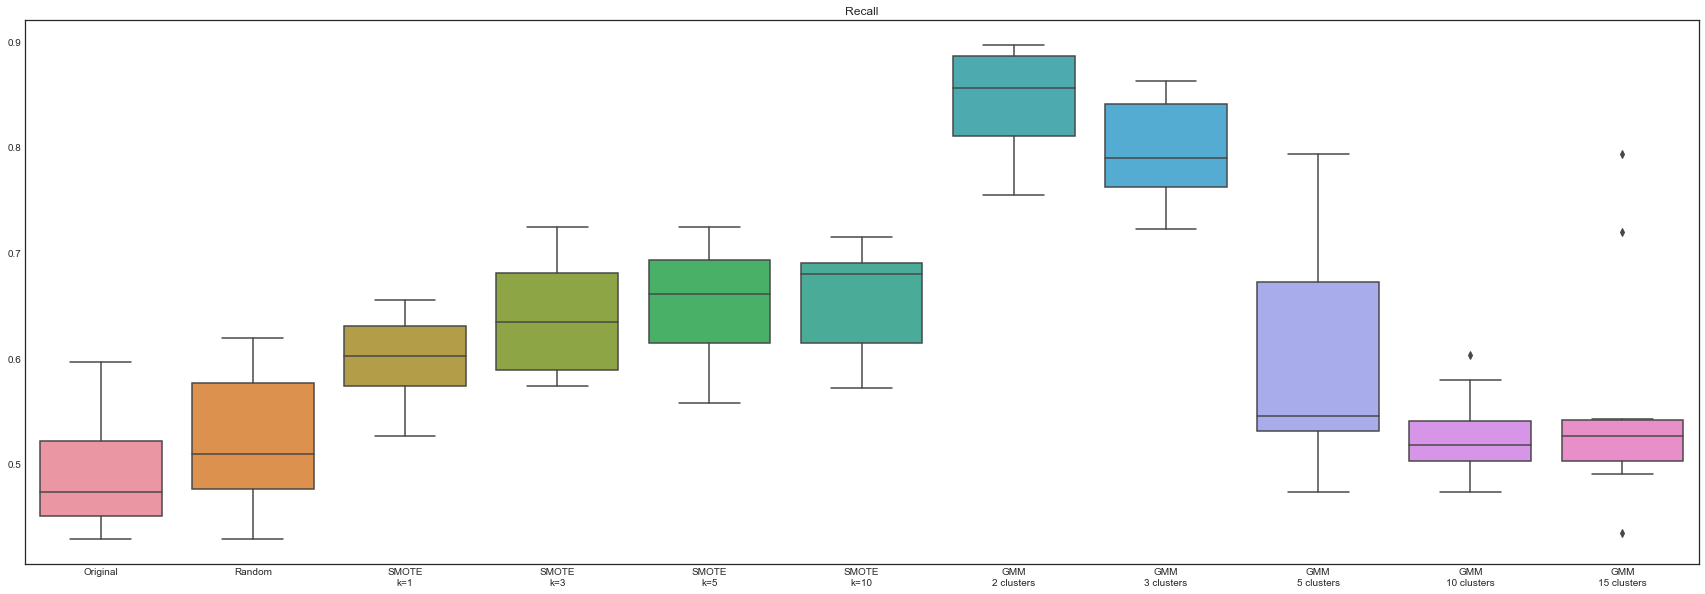

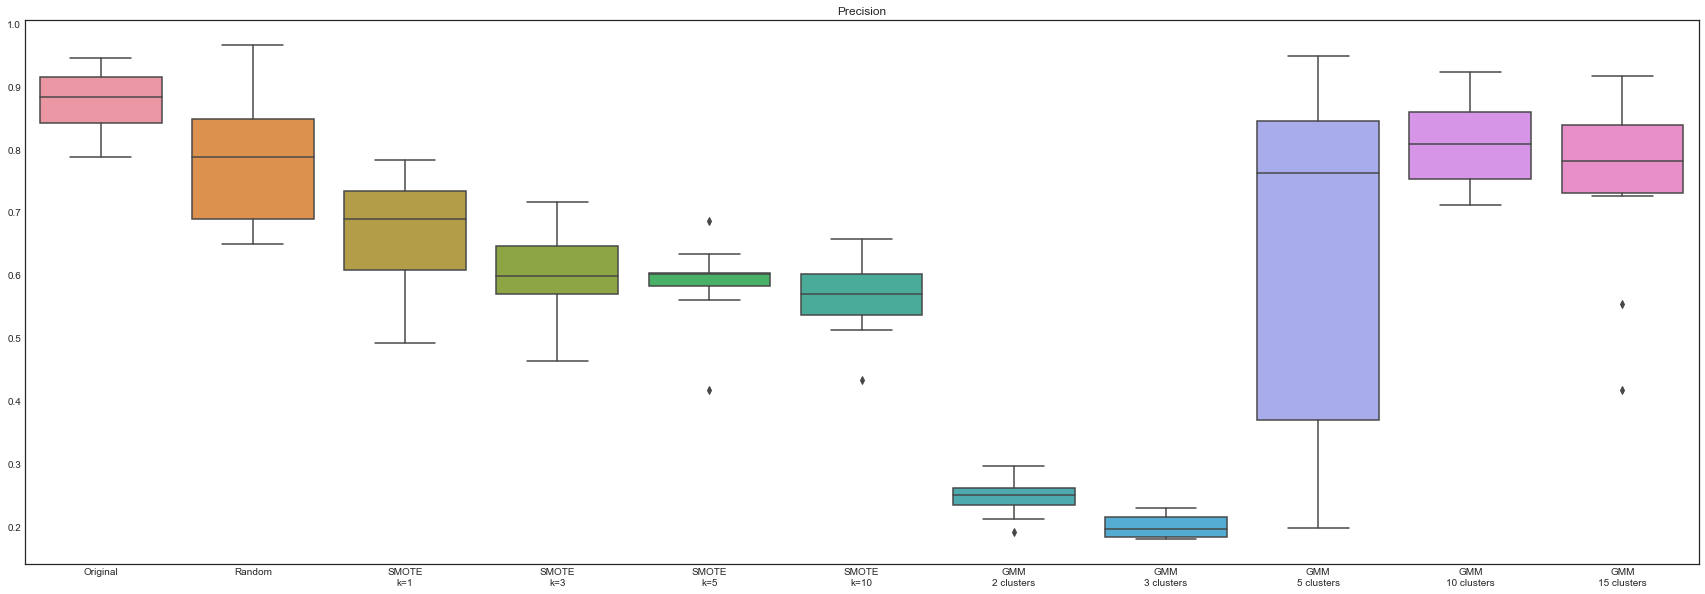

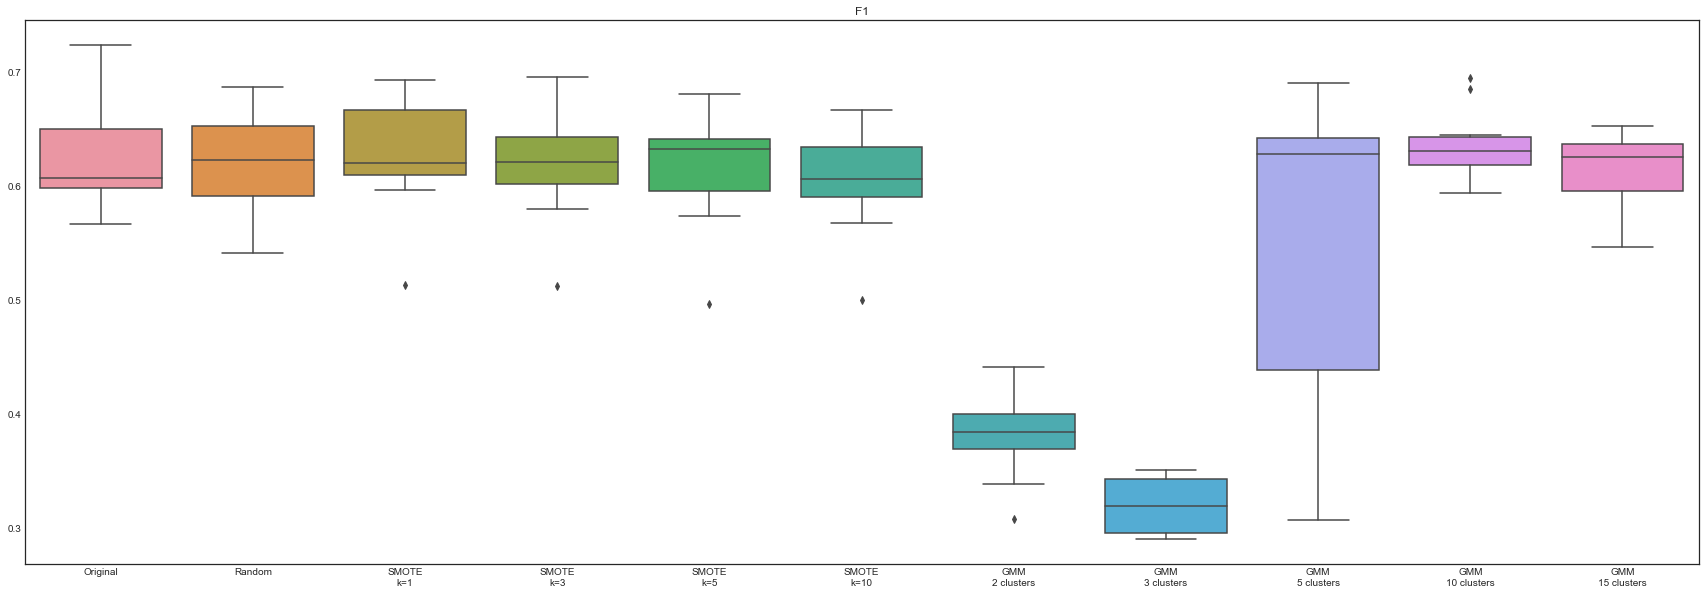

In [14]:
metrics = ["ROC AUC", "PR AUC", "Max F1", 
           "Balanced Accuracy", "Recall",
           "Precision", "F1"]

for metric in metrics:
    plt.figure(figsize=(30, 10))

    data = pd.DataFrame(data={
        "Original": results_original[metric], 
        "Random": results_random[metric],
        "SMOTE\nk=1": results_smote_1[metric],
        "SMOTE\nk=3": results_smote_3[metric],
        "SMOTE\nk=5": results_smote_5[metric],
        "SMOTE\nk=10": results_smote_10[metric],
        "GMM\n2 clusters": results_gmm_2[metric],
        "GMM\n3 clusters": results_gmm_3[metric],
        "GMM\n5 clusters": results_gmm_5[metric],
        "GMM\n10 clusters": results_gmm_10[metric],
        "GMM\n15 clusters": results_gmm_15[metric],
    })

    sns.boxplot(data=data)
    plt.title(metric)
    plt.show()